## 加载图片

现在，让我们加载一张图片。

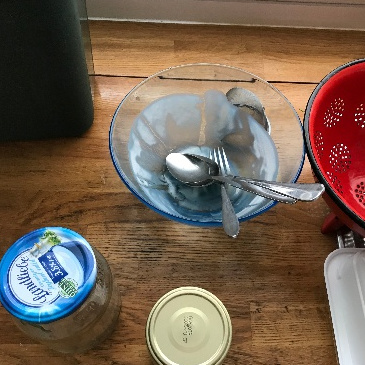

In [1]:
from PIL import Image
import requests

url = "https://github.com/timojl/clipseg/blob/master/example_image.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image

## 加载模型

接下来，让我们从[hub](https://huggingface.co/CIDAS/clipseg-rd64-refined)加载模型和它的处理器

In [2]:
from mindnlp.transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")


Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.613 seconds.
Prefix dict has been built successfully.
/home/lmh/mindnlp/mindnlp/transformers/tokenization_utils_base.py:1526: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted, and will be then set to `False` by default. 
  warnings.warn(
Some weights of the model checkpoint at CIDAS/clipseg-rd64-refined were not used when initializing CLIPSegForImageSegmentation: ['clip.text_model.embeddings.position_ids', 'clip.vision_model.embeddings.position_ids']
- This IS expected if you are initializing CLIPSegForImageSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CLIPSegForImageSegmentation from the checkpoint of a mode

## 为模型处理图片和文本

为了模型能够使用处理器，可以准备图片和一些提示词。

In [3]:
prompts = ["a glass", "something to fill", "wood", "a jar"]

inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="ms")

Unused or unrecognized kwargs: padding.


## 前向传播

接下来，让我们运行一轮前向传播并且可视化模型所做的预测

In [6]:
import mindspore
import matplotlib.pyplot as plt
from mindnlp.core import ops
# predict

outputs = model(**inputs)

preds = outputs.logits.unsqueeze(1)


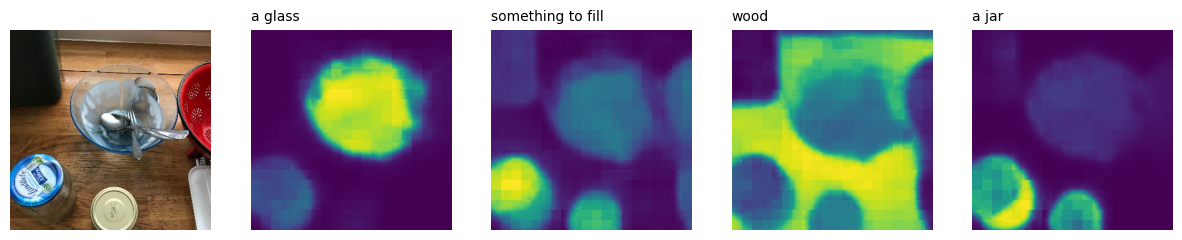

In [16]:
# visualize prediction
_, ax = plt.subplots(1, 5, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(ops.sigmoid(preds[i][0]).asnumpy()) for i in range(4)];
[ax[i+1].text(0, -15, prompts[i]) for i in range(4)];

可以看出，该模型能够以零样本的方式根据文本提示进行图像分割。很酷吧？

## 转换为二进制掩码

为了转换为二进制掩码，我从[此处](https://github.com/amrrs/stable-diffusion-prompt-inpainting)借用了一些逻辑。人们可以在预测掩码上应用 sigmoid 激活函数，并使用一些 OpenCV (cv2) 将其转换为二进制掩码。

In [18]:
filename = f"mask.png"
# here we save the second mask
plt.imsave(filename,ops.sigmoid(preds[1][0]).asnumpy())

In [20]:
import cv2

img2 = cv2.imread(filename)

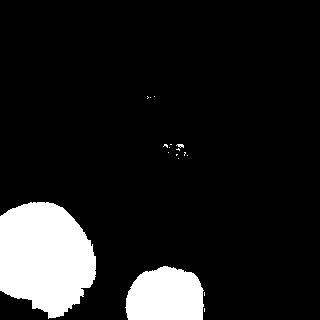

In [21]:
gray_image = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

(thresh, bw_image) = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

# fix color format
cv2.cvtColor(bw_image, cv2.COLOR_BGR2RGB)

Image.fromarray(bw_image)